# Multiclass Classification on the Fashion-MNIST Dataset

We here have used the Fashion-MNIST dataset, which is an image dataset consisting of a training set of 60,000 examples and a test set of 10,000 examples. 

Each example is a 28x28 grayscale image, belonging to one of the 10 following classes.

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

## Mount Data into Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import all Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, LSTM, Embedding, Dropout
from keras.preprocessing import image
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
from keras.wrappers.scikit_learn import KerasClassifier

## Preprocessing

### 1. Read Dataset

In [ ]:
trainDataset = pd.read_csv('/content/drive/MyDrive/archive/fashion-mnist_train.csv')
testDataset = pd.read_csv('drive/MyDrive/archive/fashion-mnist_test.csv')
trainDataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


Below we can see the shape of the train and test dataset

The train dataset has 60000 data points while the test dataset has 10000 datapoints each with 784 having coloums which have the pixel value


In [ ]:
print(trainDataset.shape)
print(testDataset.shape)

(60000, 785)
(10000, 785)


### 2. Split the data into Input and Output Values

We can see that each row of the dataset consists of the label in the first column followed by 784 pixel values. We use this to split the data.

In [ ]:
X_train = trainDataset.iloc[:,1:785].values
Y_train1 = trainDataset.iloc[:,0:1].values

X_test = testDataset.iloc[:,1:785].values
Y_test1 = testDataset.iloc[:,0:1].values

In [ ]:
print(X_train.shape)
print(Y_train1.shape)
print(X_test.shape)
print(Y_test1.shape)

(60000, 784)
(60000, 1)
(10000, 784)
(10000, 1)


### 3. Scale the Input Data

The data represents each pixel as an integer in [0, 255]. We divide the values by 255 to convert them to floats in [0, 1]


In [ ]:
X_train = X_train/255
X_test = X_test/255

### 4. One Hot Encode the Output Labels

Now we use ScikitLearn's ```OneHotEncoder``` to convert the labels which are single values into lists of 10 elements with the label which belongs to being 1 and rest is 0. This is done as we have 10 neurons in the ouput layer each denoting one class.

After using this the Y_train and Y_test will be resized from (n,1) to (n,10).

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
Y_train = ohe.fit_transform(Y_train1).toarray()
Y_test = ohe.fit_transform(Y_test1).toarray()

In [ ]:
print(Y_train.shape)
print(Y_test.shape)

(60000, 10)
(10000, 10)


### 5. Sample the Data

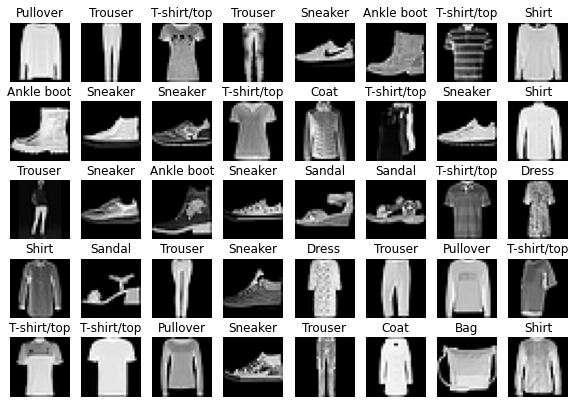

In [ ]:
labelmap = {
    0 : "T-shirt/top",
    1: "Trouser",
    2 :"Pullover",
    3 :"Dress",
    4: "Coat",
    5: "Sandal",
    6 :"Shirt",
    7 :"Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
fig = plt.figure(figsize=(10, 7))
rows = 5
columns = 8
for iter in range(rows*columns) :
  index =random.randint(0,60000)
  image = trainDataset.iloc[:,1:785].values[index]
  img = []
  for i in range(28) :
    l = []
    for j in range(28) :
      l.append(image[28*i+j])
    img.append(l)
  fig.add_subplot(rows, columns, iter+1)
  plt.title(labelmap.get(trainDataset.iloc[:,0:1].values[index][0]))
  #plt.title(trainDataset.iloc[:,0:1].values[index][0])
  plt.axis("off")
  plt.imshow(img,cmap='gray', vmin=0, vmax=255)
plt.show()

## Training

### 1. Create the Model

Now we define our model and use a function ```create_model``` which returns the model to be used in our Random Search Function. The function takes the following inputs
  - ```nl``` which is the number of layers,
  - ```nn``` which is an array of the number of neurons in each layer,
  - ```lr``` which is the learning rate of the, and
  - ```act``` which is the activation function.


We then create ```nl``` hidden layers and the output layer. We use the **Softmax Activation** function for the output layer as it is a **Multiclass Classification Problem**. We use the **RMSProp Optimizer** to optimize our ANN and use **Cross Entropy Error** as our loss function and metric.

In [ ]:
def create_model(nl=1, nn=1000, lr=0.01, act="relu"):
   
    opt = keras.optimizers.RMSprop(lr=lr)
    print(nn[0])
    print(nl)                                        
    model = Sequential()
    # for the firt layer we need to specify the input dimensions
    first=True
    for i in range(nl):
        if first:
            model.add(Dense(nn[i], input_dim=X_train[0].size, activation=act,))
            first=False
        else: 
            model.add(Dense(nn[i], activation=act))                  
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'],)
    return model

Here we use the scikit keras wrapper the KerasClassifier to make our model with the following parameters.

1.   ```build_fn``` which we define as the ```create_model``` function.
2.   Number of Epochs = 35
3.   Batch Size = 600

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=35, batch_size=600, verbose=1)

### 2. Random Search

#### 2.1 Initialize param_grid

Now we deine the range from which we want to select and tune the parameters.The range chosen is as specified in the question for the assignment. The range is as following:
1. ```nl``` - Uniform Distribution of Integers ```[5, 30]```,
2. ```nn``` - Uniform Distribution of Integers ```[16, 1024]```
3. ```lr``` - Randomly picked from set ```{0.01, 0.001, 0.0001, 0.00001}```
4. ```act``` - Randomly picked from set ```{relu, tanh}```.

Finally we make a dictionary param_grid with all the parameters to be used by Scikit Learn's ```RandomSearchCV``` method.

In [ ]:
numberOfLayers = list(range(5,31))
activation = ["relu","tanh"]
numberOfNeurons = []
temp = list(range(16,1025))
for i in range(30):
  random.shuffle(temp)
  numberOfNeurons.append(tuple(temp[0:31])) 
print(numberOfNeurons)
lr = [0.01, 0.001, 0.0001, 0.00001]
param_grid = dict(nl=numberOfLayers,nn=numberOfNeurons,lr=lr,act=activation)


[(277, 472, 996, 115, 536, 707, 407, 822, 155, 804, 868, 284, 955, 23, 304, 65, 312, 336, 1011, 827, 945, 91, 630, 609, 223, 664, 152, 910, 665, 485, 560), (637, 773, 136, 935, 455, 128, 786, 1015, 843, 616, 297, 226, 788, 918, 329, 842, 796, 117, 992, 832, 760, 719, 72, 408, 980, 366, 152, 930, 765, 396, 81), (171, 478, 298, 1002, 511, 164, 624, 385, 815, 400, 415, 450, 748, 749, 1009, 959, 942, 181, 112, 622, 442, 487, 971, 820, 245, 981, 175, 498, 302, 452, 93), (882, 167, 673, 662, 878, 928, 738, 314, 681, 46, 18, 576, 783, 249, 793, 316, 435, 1015, 100, 911, 393, 592, 343, 774, 159, 941, 99, 874, 226, 949, 28), (65, 110, 990, 983, 323, 114, 1012, 902, 447, 529, 737, 364, 996, 349, 368, 913, 366, 934, 658, 716, 465, 911, 339, 942, 216, 689, 265, 601, 245, 520, 769), (53, 990, 726, 952, 412, 587, 865, 462, 304, 893, 766, 21, 549, 417, 609, 996, 847, 520, 736, 951, 471, 288, 671, 41, 915, 150, 788, 344, 923, 328, 884), (376, 299, 411, 262, 135, 122, 601, 270, 548, 466, 236, 865, 377,

#### 2.2 Run RandomizedSearchCV and Train the Model

Now we make our RandomizedSearchCV model with number of iteration as 10 and with a 3 fold cross validation to evaluate the model.

We then fit our model in the next code cell.

In [ ]:
grid = RandomizedSearchCV(estimator=model, cv=KFold(4), param_distributions=param_grid, 
                          verbose=20,  n_iter=20, n_jobs=1)

In [ ]:
grid_result = grid.fit(X_train, Y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] nn=(137, 297, 92, 139, 937, 957, 126, 821, 130, 276, 674, 256, 711, 817, 868, 467, 815, 561, 742, 782, 392, 434, 218, 493, 99, 147, 22, 648, 442, 736, 305), nl=14, lr=0.0001, act=tanh 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


137
14
Epoch 1/35
75/75 [==============================] - 3s 20ms/step - loss: 1.1611 - accuracy: 0.5696
Epoch 2/35
75/75 [==============================] - 1s 17ms/step - loss: 0.6143 - accuracy: 0.7707
Epoch 3/35
75/75 [==============================] - 1s 17ms/step - loss: 0.5462 - accuracy: 0.7973
Epoch 4/35
75/75 [==============================] - 1s 17ms/step - loss: 0.5079 - accuracy: 0.8134
Epoch 5/35
75/75 [==============================] - 1s 18ms/step - loss: 0.4679 - accuracy: 0.8278
Epoch 6/35
75/75 [==============================] - 1s 17ms/step - loss: 0.4516 - accuracy: 0.8335
Epoch 7/35
75/75 [==============================] - 1s 17ms/step - loss: 0.4336 - accuracy: 0.8408
Epoch 8/35
75/75 [==============================] - 1s 17ms/step - loss: 0.4250 - accuracy: 0.8417
Epoch 9/35
75/75 [==============================] - 1s 18ms/step - loss: 0.4168 - accuracy: 0.8447
Epoch 10/35
75/75 [==============================] - 1s 17ms/step - loss: 0.3953 - accuracy: 0.8536
Ep

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.2s remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 3s 17ms/step - loss: 1.1345 - accuracy: 0.5819
Epoch 2/35
75/75 [==============================] - 1s 17ms/step - loss: 0.6136 - accuracy: 0.7685
Epoch 3/35
75/75 [==============================] - 1s 17ms/step - loss: 0.5495 - accuracy: 0.7977
Epoch 4/35
75/75 [==============================] - 1s 17ms/step - loss: 0.5161 - accuracy: 0.8105
Epoch 5/35
75/75 [==============================] - 1s 18ms/step - loss: 0.4709 - accuracy: 0.8302
Epoch 6/35
75/75 [==============================] - 1s 17ms/step - loss: 0.4555 - accuracy: 0.8338
Epoch 7/35
75/75 [==============================] - 1s 17ms/step - loss: 0.4395 - accuracy: 0.8382
Epoch 8/35
75/75 [==============================] - 1s 18ms/step - loss: 0.4229 - accuracy: 0.8453
Epoch 9/35
75/75 [==============================] - 1s 17ms/step - loss: 0.4138 - accuracy: 0.8470
Epoch 10/35
75/75 [==============================] - 1s 17ms/step - loss: 0.3944 - accuracy: 0.8520
Epoch 11/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 3s 18ms/step - loss: 1.1205 - accuracy: 0.5837
Epoch 2/35
75/75 [==============================] - 1s 18ms/step - loss: 0.5945 - accuracy: 0.7849
Epoch 3/35
75/75 [==============================] - 1s 17ms/step - loss: 0.5408 - accuracy: 0.8007
Epoch 4/35
75/75 [==============================] - 1s 18ms/step - loss: 0.5000 - accuracy: 0.8154
Epoch 5/35
75/75 [==============================] - 1s 18ms/step - loss: 0.4750 - accuracy: 0.8281
Epoch 6/35
75/75 [==============================] - 1s 17ms/step - loss: 0.4550 - accuracy: 0.8334
Epoch 7/35
75/75 [==============================] - 1s 18ms/step - loss: 0.4459 - accuracy: 0.8377
Epoch 8/35
75/75 [==============================] - 1s 18ms/step - loss: 0.4235 - accuracy: 0.8454
Epoch 9/35
75/75 [==============================] - 1s 18ms/step - loss: 0.4055 - accuracy: 0.8521
Epoch 10/35
75/75 [==============================] - 1s 18ms/step - loss: 0.3982 - accuracy: 0.8526
Epoch 11/

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 3s 17ms/step - loss: 1.1525 - accuracy: 0.5604
Epoch 2/35
75/75 [==============================] - 1s 17ms/step - loss: 0.6301 - accuracy: 0.7617
Epoch 3/35
75/75 [==============================] - 1s 17ms/step - loss: 0.5528 - accuracy: 0.7952
Epoch 4/35
75/75 [==============================] - 1s 18ms/step - loss: 0.5034 - accuracy: 0.8171
Epoch 5/35
75/75 [==============================] - 1s 17ms/step - loss: 0.4821 - accuracy: 0.8232
Epoch 6/35
75/75 [==============================] - 1s 17ms/step - loss: 0.4566 - accuracy: 0.8328
Epoch 7/35
75/75 [==============================] - 1s 18ms/step - loss: 0.4477 - accuracy: 0.8355
Epoch 8/35
75/75 [==============================] - 1s 19ms/step - loss: 0.4297 - accuracy: 0.8422
Epoch 9/35
75/75 [==============================] - 1s 17ms/step - loss: 0.4161 - accuracy: 0.8465
Epoch 10/35
75/75 [==============================] - 1s 17ms/step - loss: 0.3976 - accuracy: 0.8522
Epoch 11/

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.2min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 2s 14ms/step - loss: 1.9738 - accuracy: 0.4584
Epoch 2/35
75/75 [==============================] - 1s 14ms/step - loss: 1.1576 - accuracy: 0.6366
Epoch 3/35
75/75 [==============================] - 1s 14ms/step - loss: 0.8479 - accuracy: 0.6969
Epoch 4/35
75/75 [==============================] - 1s 14ms/step - loss: 0.7224 - accuracy: 0.7419
Epoch 5/35
75/75 [==============================] - 1s 14ms/step - loss: 0.6553 - accuracy: 0.7655
Epoch 6/35
75/75 [==============================] - 1s 14ms/step - loss: 0.6068 - accuracy: 0.7843
Epoch 7/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5741 - accuracy: 0.7961
Epoch 8/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5612 - accuracy: 0.8002
Epoch 9/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5424 - accuracy: 0.8089
Epoch 10/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5317 - accuracy: 0.8093
Epoch 11/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.9min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 2s 14ms/step - loss: 2.0076 - accuracy: 0.4493
Epoch 2/35
75/75 [==============================] - 1s 14ms/step - loss: 1.1641 - accuracy: 0.6435
Epoch 3/35
75/75 [==============================] - 1s 14ms/step - loss: 0.8493 - accuracy: 0.6949
Epoch 4/35
75/75 [==============================] - 1s 14ms/step - loss: 0.7272 - accuracy: 0.7330
Epoch 5/35
75/75 [==============================] - 1s 14ms/step - loss: 0.6579 - accuracy: 0.7649
Epoch 6/35
75/75 [==============================] - 1s 14ms/step - loss: 0.6239 - accuracy: 0.7757
Epoch 7/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5922 - accuracy: 0.7897
Epoch 8/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5706 - accuracy: 0.7967
Epoch 9/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5462 - accuracy: 0.8065
Epoch 10/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5296 - accuracy: 0.8122
Epoch 11/

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.5min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 2s 14ms/step - loss: 2.0157 - accuracy: 0.4213
Epoch 2/35
75/75 [==============================] - 1s 14ms/step - loss: 1.1824 - accuracy: 0.6447
Epoch 3/35
75/75 [==============================] - 1s 14ms/step - loss: 0.8453 - accuracy: 0.7091
Epoch 4/35
75/75 [==============================] - 1s 14ms/step - loss: 0.7002 - accuracy: 0.7477
Epoch 5/35
75/75 [==============================] - 1s 14ms/step - loss: 0.6348 - accuracy: 0.7683
Epoch 6/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5974 - accuracy: 0.7822
Epoch 7/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5762 - accuracy: 0.7913
Epoch 8/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5601 - accuracy: 0.7987
Epoch 9/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5429 - accuracy: 0.8058
Epoch 10/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5325 - accuracy: 0.8105
Epoch 11/

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  5.2min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 2s 14ms/step - loss: 1.9941 - accuracy: 0.4320
Epoch 2/35
75/75 [==============================] - 1s 14ms/step - loss: 1.2035 - accuracy: 0.6237
Epoch 3/35
75/75 [==============================] - 1s 14ms/step - loss: 0.8697 - accuracy: 0.6907
Epoch 4/35
75/75 [==============================] - 1s 14ms/step - loss: 0.7234 - accuracy: 0.7398
Epoch 5/35
75/75 [==============================] - 1s 14ms/step - loss: 0.6502 - accuracy: 0.7679
Epoch 6/35
75/75 [==============================] - 1s 14ms/step - loss: 0.6023 - accuracy: 0.7852
Epoch 7/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5745 - accuracy: 0.7976
Epoch 8/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5499 - accuracy: 0.8049
Epoch 9/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5407 - accuracy: 0.8069
Epoch 10/35
75/75 [==============================] - 1s 14ms/step - loss: 0.5214 - accuracy: 0.8118
Epoch 11/

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.8min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 6s 39ms/step - loss: 1.3944 - accuracy: 0.4796
Epoch 2/35
75/75 [==============================] - 3s 37ms/step - loss: 0.6654 - accuracy: 0.7523
Epoch 3/35
75/75 [==============================] - 3s 38ms/step - loss: 0.5709 - accuracy: 0.7928
Epoch 4/35
75/75 [==============================] - 3s 38ms/step - loss: 0.5193 - accuracy: 0.8120
Epoch 5/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4954 - accuracy: 0.8188
Epoch 6/35
75/75 [==============================] - 3s 37ms/step - loss: 0.4542 - accuracy: 0.8337
Epoch 7/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4341 - accuracy: 0.8395
Epoch 8/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4204 - accuracy: 0.8443
Epoch 9/35
75/75 [==============================] - 3s 38ms/step - loss: 0.3944 - accuracy: 0.8521
Epoch 10/35
75/75 [==============================] - 3s 38ms/step - loss: 0.3815 - accuracy: 0.8574
Epoch 11/

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  7.6min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 5s 39ms/step - loss: 1.3334 - accuracy: 0.4844
Epoch 2/35
75/75 [==============================] - 3s 37ms/step - loss: 0.6570 - accuracy: 0.7610
Epoch 3/35
75/75 [==============================] - 3s 37ms/step - loss: 0.5726 - accuracy: 0.7906
Epoch 4/35
75/75 [==============================] - 3s 37ms/step - loss: 0.5386 - accuracy: 0.8026
Epoch 5/35
75/75 [==============================] - 3s 37ms/step - loss: 0.5166 - accuracy: 0.8137
Epoch 6/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4816 - accuracy: 0.8238
Epoch 7/35
75/75 [==============================] - 3s 37ms/step - loss: 0.4570 - accuracy: 0.8354
Epoch 8/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4328 - accuracy: 0.8415
Epoch 9/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4153 - accuracy: 0.8491
Epoch 10/35
75/75 [==============================] - 3s 38ms/step - loss: 0.3991 - accuracy: 0.8532
Epoch 11/

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  9.3min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 6s 39ms/step - loss: 1.3508 - accuracy: 0.4928
Epoch 2/35
75/75 [==============================] - 3s 37ms/step - loss: 0.6728 - accuracy: 0.7502
Epoch 3/35
75/75 [==============================] - 3s 37ms/step - loss: 0.5839 - accuracy: 0.7877
Epoch 4/35
75/75 [==============================] - 3s 37ms/step - loss: 0.5249 - accuracy: 0.8073
Epoch 5/35
75/75 [==============================] - 3s 37ms/step - loss: 0.4832 - accuracy: 0.8233
Epoch 6/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4552 - accuracy: 0.8327
Epoch 7/35
75/75 [==============================] - 3s 37ms/step - loss: 0.4351 - accuracy: 0.8379
Epoch 8/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4195 - accuracy: 0.8457
Epoch 9/35
75/75 [==============================] - 3s 38ms/step - loss: 0.3974 - accuracy: 0.8516
Epoch 10/35
75/75 [==============================] - 3s 37ms/step - loss: 0.3907 - accuracy: 0.8560
Epoch 11/

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 11.0min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 6s 40ms/step - loss: 1.3830 - accuracy: 0.4771
Epoch 2/35
75/75 [==============================] - 3s 38ms/step - loss: 0.6835 - accuracy: 0.7503
Epoch 3/35
75/75 [==============================] - 3s 38ms/step - loss: 0.5857 - accuracy: 0.7893
Epoch 4/35
75/75 [==============================] - 3s 38ms/step - loss: 0.5246 - accuracy: 0.8101
Epoch 5/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4964 - accuracy: 0.8229
Epoch 6/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4706 - accuracy: 0.8285
Epoch 7/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4307 - accuracy: 0.8402
Epoch 8/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4289 - accuracy: 0.8434
Epoch 9/35
75/75 [==============================] - 3s 38ms/step - loss: 0.4048 - accuracy: 0.8514
Epoch 10/35
75/75 [==============================] - 3s 37ms/step - loss: 0.3890 - accuracy: 0.8558
Epoch 11/

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 12.7min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 5s 34ms/step - loss: 1.3923 - accuracy: 0.4623
Epoch 2/35
75/75 [==============================] - 2s 32ms/step - loss: 0.6560 - accuracy: 0.7550
Epoch 3/35
75/75 [==============================] - 2s 32ms/step - loss: 0.5709 - accuracy: 0.7920
Epoch 4/35
75/75 [==============================] - 2s 32ms/step - loss: 0.5314 - accuracy: 0.8062
Epoch 5/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4880 - accuracy: 0.8236
Epoch 6/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4754 - accuracy: 0.8252
Epoch 7/35
75/75 [==============================] - 2s 32ms/step - loss: 0.4423 - accuracy: 0.8379
Epoch 8/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4346 - accuracy: 0.8413
Epoch 9/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4093 - accuracy: 0.8492
Epoch 10/35
75/75 [==============================] - 2s 33ms/step - loss: 0.3982 - accuracy: 0.8525
Epoch 11/

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 14.2min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 5s 33ms/step - loss: 1.3378 - accuracy: 0.4908
Epoch 2/35
75/75 [==============================] - 2s 33ms/step - loss: 0.6497 - accuracy: 0.7627
Epoch 3/35
75/75 [==============================] - 2s 33ms/step - loss: 0.5480 - accuracy: 0.8013
Epoch 4/35
75/75 [==============================] - 2s 33ms/step - loss: 0.5125 - accuracy: 0.8136
Epoch 5/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4783 - accuracy: 0.8255
Epoch 6/35
75/75 [==============================] - 2s 32ms/step - loss: 0.4452 - accuracy: 0.8359
Epoch 7/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4359 - accuracy: 0.8378
Epoch 8/35
75/75 [==============================] - 2s 32ms/step - loss: 0.4140 - accuracy: 0.8458
Epoch 9/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4130 - accuracy: 0.8441
Epoch 10/35
75/75 [==============================] - 2s 32ms/step - loss: 0.3956 - accuracy: 0.8535
Epoch 11/

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 15.7min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 5s 34ms/step - loss: 1.4097 - accuracy: 0.4809
Epoch 2/35
75/75 [==============================] - 2s 33ms/step - loss: 0.6731 - accuracy: 0.7477
Epoch 3/35
75/75 [==============================] - 2s 33ms/step - loss: 0.5815 - accuracy: 0.7846
Epoch 4/35
75/75 [==============================] - 2s 32ms/step - loss: 0.5504 - accuracy: 0.7981
Epoch 5/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4987 - accuracy: 0.8189
Epoch 6/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4576 - accuracy: 0.8331
Epoch 7/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4520 - accuracy: 0.8326
Epoch 8/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4169 - accuracy: 0.8443
Epoch 9/35
75/75 [==============================] - 2s 33ms/step - loss: 0.3967 - accuracy: 0.8504
Epoch 10/35
75/75 [==============================] - 2s 33ms/step - loss: 0.3801 - accuracy: 0.8569
Epoch 11/

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 17.2min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 5s 34ms/step - loss: 1.3734 - accuracy: 0.4858
Epoch 2/35
75/75 [==============================] - 2s 33ms/step - loss: 0.6675 - accuracy: 0.7549
Epoch 3/35
75/75 [==============================] - 2s 33ms/step - loss: 0.5721 - accuracy: 0.7917
Epoch 4/35
75/75 [==============================] - 2s 33ms/step - loss: 0.5303 - accuracy: 0.8061
Epoch 5/35
75/75 [==============================] - 2s 33ms/step - loss: 0.5031 - accuracy: 0.8160
Epoch 6/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4678 - accuracy: 0.8278
Epoch 7/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4367 - accuracy: 0.8407
Epoch 8/35
75/75 [==============================] - 2s 32ms/step - loss: 0.4323 - accuracy: 0.8420
Epoch 9/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4174 - accuracy: 0.8450
Epoch 10/35
75/75 [==============================] - 2s 33ms/step - loss: 0.4003 - accuracy: 0.8540
Epoch 11/

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 18.7min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 3s 21ms/step - loss: 1.1497 - accuracy: 0.5579
Epoch 2/35
75/75 [==============================] - 2s 21ms/step - loss: 0.6148 - accuracy: 0.7693
Epoch 3/35
75/75 [==============================] - 2s 21ms/step - loss: 0.5431 - accuracy: 0.7977
Epoch 4/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4895 - accuracy: 0.8174
Epoch 5/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4595 - accuracy: 0.8300
Epoch 6/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4434 - accuracy: 0.8381
Epoch 7/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4298 - accuracy: 0.8425
Epoch 8/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4075 - accuracy: 0.8490
Epoch 9/35
75/75 [==============================] - 2s 21ms/step - loss: 0.3982 - accuracy: 0.8506
Epoch 10/35
75/75 [==============================] - 2s 21ms/step - loss: 0.3787 - accuracy: 0.8580
Epoch 11/

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 19.7min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 3s 21ms/step - loss: 1.1437 - accuracy: 0.5583
Epoch 2/35
75/75 [==============================] - 2s 21ms/step - loss: 0.5971 - accuracy: 0.7752
Epoch 3/35
75/75 [==============================] - 2s 21ms/step - loss: 0.5313 - accuracy: 0.8070
Epoch 4/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4978 - accuracy: 0.8146
Epoch 5/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4658 - accuracy: 0.8269
Epoch 6/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4367 - accuracy: 0.8384
Epoch 7/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4227 - accuracy: 0.8433
Epoch 8/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4110 - accuracy: 0.8480
Epoch 9/35
75/75 [==============================] - 2s 22ms/step - loss: 0.3912 - accuracy: 0.8546
Epoch 10/35
75/75 [==============================] - 2s 24ms/step - loss: 0.3846 - accuracy: 0.8573
Epoch 11/

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 20.6min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 3s 21ms/step - loss: 1.1289 - accuracy: 0.5815
Epoch 2/35
75/75 [==============================] - 2s 22ms/step - loss: 0.6143 - accuracy: 0.7690
Epoch 3/35
75/75 [==============================] - 2s 21ms/step - loss: 0.5307 - accuracy: 0.8025
Epoch 4/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4855 - accuracy: 0.8206
Epoch 5/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4663 - accuracy: 0.8227
Epoch 6/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4364 - accuracy: 0.8355
Epoch 7/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4196 - accuracy: 0.8448
Epoch 8/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4063 - accuracy: 0.8490
Epoch 9/35
75/75 [==============================] - 2s 22ms/step - loss: 0.3989 - accuracy: 0.8488
Epoch 10/35
75/75 [==============================] - 2s 21ms/step - loss: 0.3819 - accuracy: 0.8582
Epoch 11/

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 21.6min remaining:    0.0s


Epoch 1/35
75/75 [==============================] - 3s 21ms/step - loss: 1.1113 - accuracy: 0.5832
Epoch 2/35
75/75 [==============================] - 2s 21ms/step - loss: 0.5963 - accuracy: 0.7779
Epoch 3/35
75/75 [==============================] - 2s 21ms/step - loss: 0.5189 - accuracy: 0.8085
Epoch 4/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4885 - accuracy: 0.8198
Epoch 5/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4562 - accuracy: 0.8327
Epoch 6/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4346 - accuracy: 0.8394
Epoch 7/35
75/75 [==============================] - 2s 21ms/step - loss: 0.4158 - accuracy: 0.8464
Epoch 8/35
75/75 [==============================] - 2s 21ms/step - loss: 0.3929 - accuracy: 0.8540
Epoch 9/35
75/75 [==============================] - 2s 21ms/step - loss: 0.3926 - accuracy: 0.8556
Epoch 10/35
75/75 [==============================] - 2s 21ms/step - loss: 0.3787 - accuracy: 0.8588
Epoch 11/

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 100.8min finished


Epoch 1/35
100/100 [==============================] - 4s 24ms/step - loss: 2.2585 - accuracy: 0.1603
Epoch 2/35
100/100 [==============================] - 2s 24ms/step - loss: 1.2164 - accuracy: 0.4529
Epoch 3/35
100/100 [==============================] - 2s 23ms/step - loss: 0.7745 - accuracy: 0.6910
Epoch 4/35
100/100 [==============================] - 2s 23ms/step - loss: 0.6560 - accuracy: 0.7295
Epoch 5/35
100/100 [==============================] - 2s 23ms/step - loss: 0.5705 - accuracy: 0.7707
Epoch 6/35
100/100 [==============================] - 2s 23ms/step - loss: 0.5065 - accuracy: 0.8160
Epoch 7/35
100/100 [==============================] - 2s 23ms/step - loss: 0.4705 - accuracy: 0.8292
Epoch 8/35
100/100 [==============================] - 2s 23ms/step - loss: 0.4525 - accuracy: 0.8415
Epoch 9/35
100/100 [==============================] - 2s 23ms/step - loss: 0.4153 - accuracy: 0.8527
Epoch 10/35
100/100 [==============================] - 2s 23ms/step - loss: 0.3869 - accura

#### 3. Store the Results of RandomizedSearchCV

Here we make a dataframe to store all the results of all the iterations made by the RandomizedSearch in a csv file.

We also print the best parameters which gave the highest accuracy to us.

In [ ]:
cv_results_df = pd.DataFrame(grid_result.cv_results_)
cv_results_df.to_csv('drive/MyDrive/random_search.csv')

print("The best parameters are")
print("Neurons :- ", grid_result.best_params_.get("nn")[0:grid_result.best_params_.get("nl")])
print("Number of layers :- ", grid_result.best_params_.get("nl"))
print("Learning rate :- ", grid_result.best_params_.get("lr"))
print("Activation Functions :- ", grid_result.best_params_.get("act"))

The best parameters are
Neurons :-  (637, 773, 136, 935, 455, 128, 786, 1015, 843, 616, 297, 226, 788)
Number of layers :-  13
Learning rate :-  0.001
Activation Functions :-  relu


## Testing

Now we get the best_model using the ```grid_result.best_estimator_``` and try to predict the labels in the Test Dataset. We measure the accuracy as the percentage of correct outputs.

In [ ]:
best_model = grid_result.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)
a = 0;
for i in range(10000) :
  if y_pred[i] == Y_test1[i] :
    a = a + 1
accuracy = (a/y_pred.size)*100
print("Upon predicting the model with the test data we get the following Accuracy")
print("Accuracy is ",accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


17/17 [==============================] - 0s 6ms/step
Upon predicting the model with the test data we get the following Accuracy
Accuracy is  89.48


## Result

We obtained the following results after Performing Multi Class Classification on Fashion-MNIST using a Deep Neural Network and Optimizing its parameters using RandomSearchCV

1. Optimal Parameters were found to be

  - Number of layers :-  11
  - Neurons in each layer :- (538, 1016, 213, 492, 447, 881, 535, 348, 915, 58, 706)
  - Learning rate :-  0.0001
  - Activation Functions :-  relu

2. The final accuracy obtained on the test dataset was **89.48%**